In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
from scipy import stats
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pickle
import os
import string

import torch
import torch.nn as nn
import joblib

In [2]:
class MonteCarloDropout(nn.Dropout):
    def forward(self, input):
        return nn.functional.dropout(input, self.p, True, self.inplace)

class MLP(nn.Module):
    def __init__(self, input_size):
        super(MLP, self).__init__()

        self.layers = nn.Sequential(
            nn.Linear(input_size, 2056),
            nn.ReLU(),
            #MonteCarloDropout(0.2),
            nn.Linear(2056, 1024),
            nn.ReLU(),
            #MonteCarloDropout(0.2), 
	        nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            MonteCarloDropout(0.2), 
            nn.Linear(128, 1),
        )

    def forward(self, x):
        return self.layers(x)

In [3]:
mid = "10pct"

In [4]:
model = MLP(10)
model.load_state_dict(torch.load(f'./{mid}_outputs/{mid}_model.pt'))
model.eval()

MLP(
  (layers): Sequential(
    (0): Linear(in_features=10, out_features=2056, bias=True)
    (1): ReLU()
    (2): Linear(in_features=2056, out_features=1024, bias=True)
    (3): ReLU()
    (4): Linear(in_features=1024, out_features=512, bias=True)
    (5): ReLU()
    (6): Linear(in_features=512, out_features=256, bias=True)
    (7): ReLU()
    (8): Linear(in_features=256, out_features=128, bias=True)
    (9): ReLU()
    (10): MonteCarloDropout(p=0.2, inplace=False)
    (11): Linear(in_features=128, out_features=1, bias=True)
  )
)

In [5]:
y_df = pd.read_csv(f'./{mid}_outputs/{mid}_y_df.csv')
y_test = y_df.pop('y_test')
y_pred = y_df.pop('y_pred')

with open(f'./{mid}_outputs/{mid}_scaler.pkl', 'rb') as f:
    scaler = joblib.load(f)

col_names = y_df.columns.to_list()
norm_arr = scaler.inverse_transform(y_df)
y_df = pd.DataFrame(norm_arr, columns=col_names)
y_df['y_test'] = y_test
y_df['y_pred'] = y_pred
y_df['y_diff'] = y_df['y_test'] - y_df['y_pred']
y_df

,mlt,lon,lat,BY_GSE,BZ_GSE,flow_speed,proton_density,tilt_angle,mlt_sin,mlt_cos,lon_sin,lon_cos,y_test,y_pred,y_diff
0,9.155274,137.329114,58.275862,1.94,-2.36,423.0,3.41,-0.348708,0.677786,-0.735259,0.690515,-0.723318,-2.309903,-1.742470,-0.567433
1,7.943460,119.151899,63.793103,-2.21,0.72,447.0,4.44,0.550054,0.873331,-0.487127,0.881700,-0.471811,-3.825655,-3.798225,-0.027430
2,11.578903,173.683544,76.206897,-0.93,-4.37,365.0,9.04,0.519618,0.110020,-0.993929,0.127349,-0.991858,-1.858982,-1.855170,-0.003813
3,1.884388,28.265823,50.000000,-0.67,-1.16,417.0,3.43,-0.459101,0.473563,0.880760,0.458119,0.888891,-0.643864,-0.637565,-0.006299
4,0.000000,360.000000,85.862069,-2.62,-8.02,409.0,3.48,0.312663,0.000000,1.000000,-0.017452,0.999848,-21.529451,-19.279299,-2.250152
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1099003,5.822785,87.341772,52.758621,1.79,-0.41,314.0,5.92,-0.239091,0.998924,0.046378,0.997962,0.063805,-3.109497,-1.293871,-1.815626
1099004,20.667511,310.012658,56.896552,-3.74,-5.59,631.0,4.07,0.482715,-0.765902,0.642957,-0.777007,0.629492,-0.792244,9.272056,-10.064300
1099005,3.399156,50.987342,54.137931,-5.94,6.25,430.0,3.16,0.249001,0.777007,0.629492,0.765902,0.642957,-3.782162,-3.139639,-0.642523
1099006,23.697046,355.455696,50.000000,-3.19,1.10,446.0,2.44,-0.280699,-0.079230,0.996856,-0.096615,0.995322,2.419308,0.590526,1.828782


In [6]:
y_df['lon'] = y_df['lon'].round()
y_df['lat'] = y_df['lat'].round()
y_df = y_df.set_index(['lat', 'lon']) 
y_df = y_df.groupby(['lat', 'lon']).mean()
y_ds = y_df.to_xarray()
y_ds

<xarray.Dataset> Size: 250kB
Dimensions:         (lat: 30, lon: 80)
Coordinates:
  * lat             (lat) float64 240B 50.0 51.0 53.0 54.0 ... 87.0 89.0 90.0
  * lon             (lon) float64 640B 1.0 6.0 10.0 15.0 ... 351.0 355.0 360.0
Data variables: (12/13)
    mlt             (lat, lon) float64 19kB 0.06667 0.3696 0.6726 ... 23.7 0.0
    BY_GSE          (lat, lon) float64 19kB -0.2702 -0.2639 ... -0.059 -0.395
    BZ_GSE          (lat, lon) float64 19kB -0.02979 0.6857 ... 0.2269 0.1725
    flow_speed      (lat, lon) float64 19kB 441.0 423.6 432.4 ... 434.8 430.1
    proton_density  (lat, lon) float64 19kB 6.051 6.854 6.157 ... 6.661 6.868
    tilt_angle      (lat, lon) float64 19kB -0.01927 -0.009387 ... -0.01221
    ...              ...
    mlt_cos         (lat, lon) float64 19kB 0.9998 0.9953 0.9845 ... 0.9969 1.0
    lon_sin         (lat, lon) float64 19kB 0.0 0.07923 ... -0.09662 -0.01745
    lon_cos         (lat, lon) float64 19kB 1.0 0.9969 0.9874 ... 0.9953 0.9998
    y_test          (lat, lon) float64 19kB 1.717 1.178 0.8999 ... -0.5689 -1.41
    y_pred          (lat, lon) float64 19kB 1.552 1.017 0.7509 ... -1.192 -1.667
    y_diff          (lat, lon) float64 19kB 0.1657 0.1608 0.149 ... 0.6227 0.257

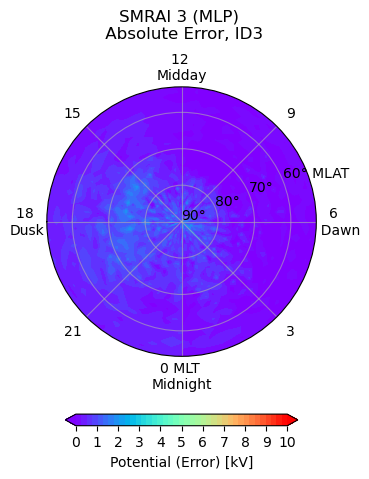

In [7]:
# Define the polar plot parameters
theta = np.linspace(0, 360, 80) - 90
theta_rad = theta / 360 * 2 * np.pi
r = 90 - np.linspace(53.1, 89.7, 30)
shrink = .5

abs_error = (y_ds['y_diff'].values)

fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(6,5))

c_true = ax.contourf(theta_rad, r, abs_error, levels=np.linspace(0, 10, 40), cmap='rainbow', extend='both')
ax.set_ylim([0, 37])
ax.set_yticks([0, 10, 20, 30])
ax.set_yticklabels(["90°", "80°", "70°", "60° MLAT"])
ax.set_xlim([-np.pi, np.pi])
ax.set_xticks(np.linspace(-np.pi, np.pi, 9)[1:])
ax.set_xticklabels(["21", "0 MLT \nMidnight", "3", "6 \n  Dawn", "9", "12 \nMidday", "15", "18 \nDusk"])
ax.set_title(f'SMRAI 3 (MLP) \n Absolute Error, ID3', pad=10, fontsize=12)
plt.colorbar(c_true, ax=ax, label='Potential (Error) [kV]', shrink=shrink, pad=0.15, ticks=np.arange(0,11,1), orientation='horizontal')
ax.grid(True, linestyle='-', alpha=0.6)

#plt.savefig('MLP_potential_ID3.png', dpi=300, bbox_inches='tight')